In [1]:
%pip install torch torchvision kaggle opencv-python scikit-learn torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 4.6 MB/s eta 0:00:00


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
import kaggle
import pathlib
import torch
import torchvision
import zipfile
import cv2
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, random_split


if torch.cuda.is_available():
    print("Мы счастливые обладатели видеокарты от AMD/Apple/Nvidia, потому можем позволить себе использовать GPU для ускорения")
    device = torch.device("cuda")
else:
    print("GPU ускорение нам недоступно, а значит, придётся запастись терпением")
    device = torch.device("cpu")

kaggle.api.competition_download_files("ml-intensive-yandex-autumn-2023", path="dataset")
dataset_path = pathlib.Path("dataset") / "data"

if not os.path.exists(dataset_path):
    with zipfile.ZipFile("./dataset/ml-intensive-yandex-autumn-2023.zip", 'r') as zip_ref:
        zip_ref.extractall("./dataset/")

imagePaths = [filename for filename in os.listdir(dataset_path / "train_images")]

Мы счастливые обладатели видеокарты от AMD/Apple/Nvidia, потому можем позволить себе использовать GPU для ускорения


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None, is_train=True):
        self.folder_path = folder_path
        self.transform = transform
        self.is_train = is_train

        if self.is_train:
            self.csv_data = pd.read_csv('dataset/data/train_answers.csv')

    def __len__(self):
        if self.is_train:
            return len(self.csv_data)
        else:
            return len(os.listdir(self.folder_path))

    def __getitem__(self, idx):
        if self.is_train:
            img_id = self.csv_data.iloc[idx, 0]
            img_name = os.path.join(self.folder_path, f"img_{img_id}.png")
            label = self.csv_data.iloc[idx, 1]
        else:
            img_name = os.path.join(self.folder_path, os.listdir(self.folder_path)[idx])
            label = None

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = Compose([
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = CustomDataset('dataset/data/train_images/', transform=transform)
train_dataset, valid_dataset = random_split(dataset, (0.9, 0.1))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

In [6]:
from torchsummary import summary
from torch import nn
import torch
import torchvision.transforms.functional as TF


class ResNet152(nn.Module):
	def __init__(self, in_channels=3):
		super(ResNet152, self).__init__()
		self.model = model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=False)
		self.model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
		num_ftrs = self.model.fc.in_features
		self.model.fc = nn.Linear(num_ftrs, 3)

	def forward(self, t):
		return self.model(t)


model = ResNet152().to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
from tqdm import tqdm


def run(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_acc, total_prec, total_rec, total_loss = 0, 0, 0, 0

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        total_acc += accuracy(pred, y).cpu().numpy() * 100
        total_prec += precision(pred, y).cpu().numpy() * 100
        total_rec += recall(pred, y).cpu().numpy() * 100
        loss = loss_function(pred, y)
        total_loss += loss.item()
        if optimizer != None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    l = len(dataloader)
    if optimizer != None:
        train_history['accuracy'].append(total_acc / l)
        train_history['precision'].append(total_prec / l)
        train_history['recall'].append(total_rec / l)
        train_history['loss'].append(total_loss / l)
    else:
        valid_history['accuracy'].append(total_acc / l)
        valid_history['precision'].append(total_prec / l)
        valid_history['recall'].append(total_rec / l)
        valid_history['loss'].append(total_loss / l)

In [8]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, Precision, Recall

def show_charts():
    clear_output()
    plt.figure(figsize=(15,10))

    metric_keys = ['loss', 'accuracy', 'precision', 'recall']
    for idx, metric in enumerate(metric_keys):
      metric_big = metric.capitalize()

      plt.subplot(2, 2, idx + 1)
      plt.plot(train_history[metric], label=f"Training {metric_big}", c='b')
      plt.plot(valid_history[metric], label=f"Validation {metric_big}", c='r')
      plt.xlabel('Epochs')
      plt.ylabel(metric_big)
      plt.legend()

    plt.show()

    for metric in metric_keys:
       print(f"Valid {metric.capitalize()}: {valid_history[metric][-1]}")

accuracy = Accuracy(task="multiclass", num_classes=3).to(device)
precision = Precision(task="multiclass", average="macro", num_classes=3).to(device)
recall =  Recall(task="multiclass", average="macro", num_classes=3).to(device)

train_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}
valid_history = {'accuracy': [], 'precision': [], 'recall': [], 'loss': []}

In [9]:
from google.colab import drive


drive_path = '/content/drive'
test_mask_path = drive_path + '/MyDrive/test_masks'

drive.mount(drive_path)

Mounted at /content/drive


In [11]:
m_state_dict = torch.load("/content/drive/MyDrive/dumps/model_dump_8.pt")
model.load_state_dict(m_state_dict)

<All keys matched successfully>

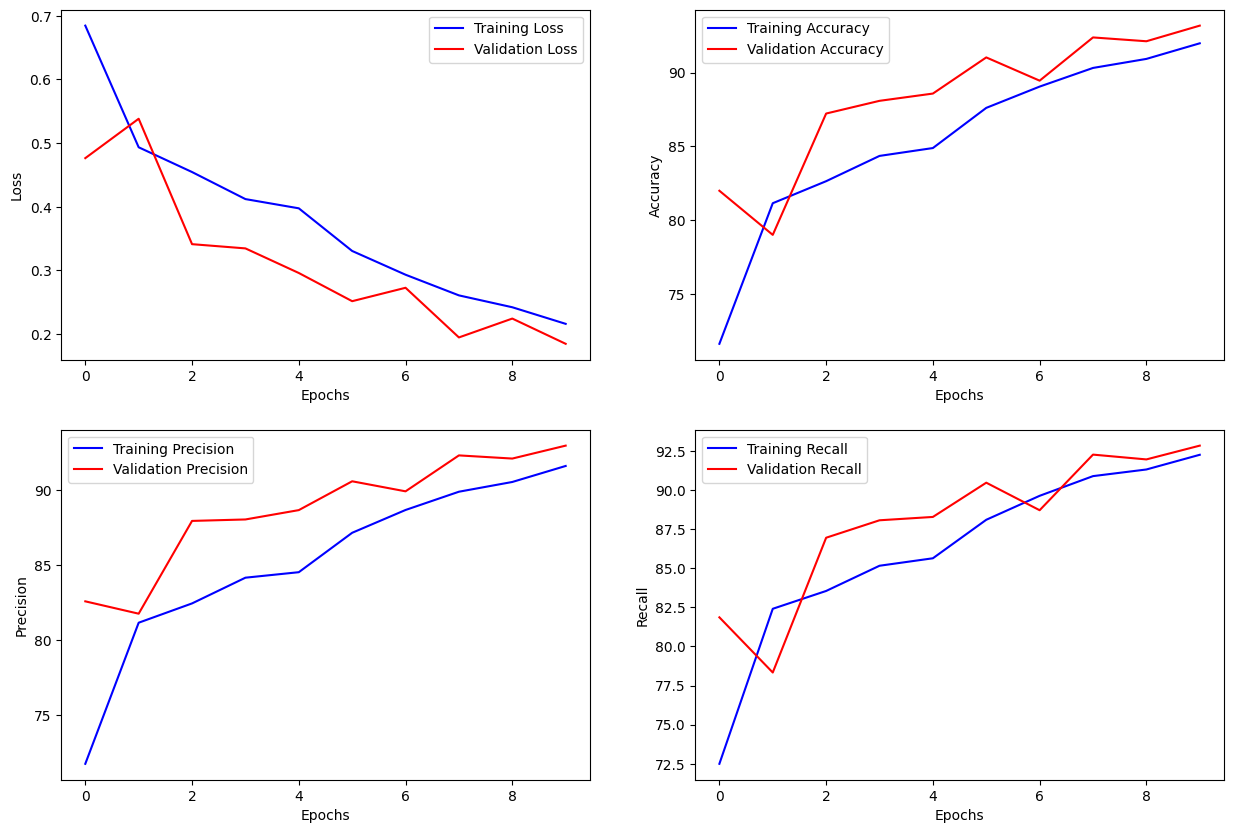

Valid Loss: 0.18462380134230535
Valid Accuracy: 93.19526627218934
Valid Precision: 92.93619679981435
Valid Recall: 92.84240892652929


  1%|          | 11/1519 [00:05<11:31,  2.18it/s]


KeyboardInterrupt: ignored

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for i in range(30):
    train_loss = run(model, train_loader, criterion, optimizer)
    test_loss = run(model, valid_loader, criterion)
    torch.save(model.state_dict(), f"/content/drive/MyDrive/dumps/model_dump_{i + 5}.pt")
    show_charts()
    scheduler.step()

In [29]:
import csv
import os
from pathlib import Path

import cv2
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm



def predict_classes():
    model.eval()
    res = []
    test_path = Path("./dataset/data/test_images")
    for i in tqdm(range(6920)):
        img = cv2.imread(str(test_path / f"img_{i}.png"))
        tensor = transform(img).unsqueeze(0).to(device)
        ans = torch.argmax(model(tensor))
        res.append([i, int(ans)])
    return res

res = predict_classes()
with open("predictions.csv", "w") as f:
    writer = csv.writer(f, lineterminator="\n")
    writer.writerow(["id", "target_feature"])
    writer.writerows(res)

100%|██████████| 6920/6920 [03:25<00:00, 33.62it/s]
